Parsed center frequency: 2300.0 MHz
Parsed sample rate: 2.4 MS/s
Loaded 102888638 complex samples
Total duration: 42.87 seconds
Обработан чанк 1/5: время от 0.00 до 10.00 сек


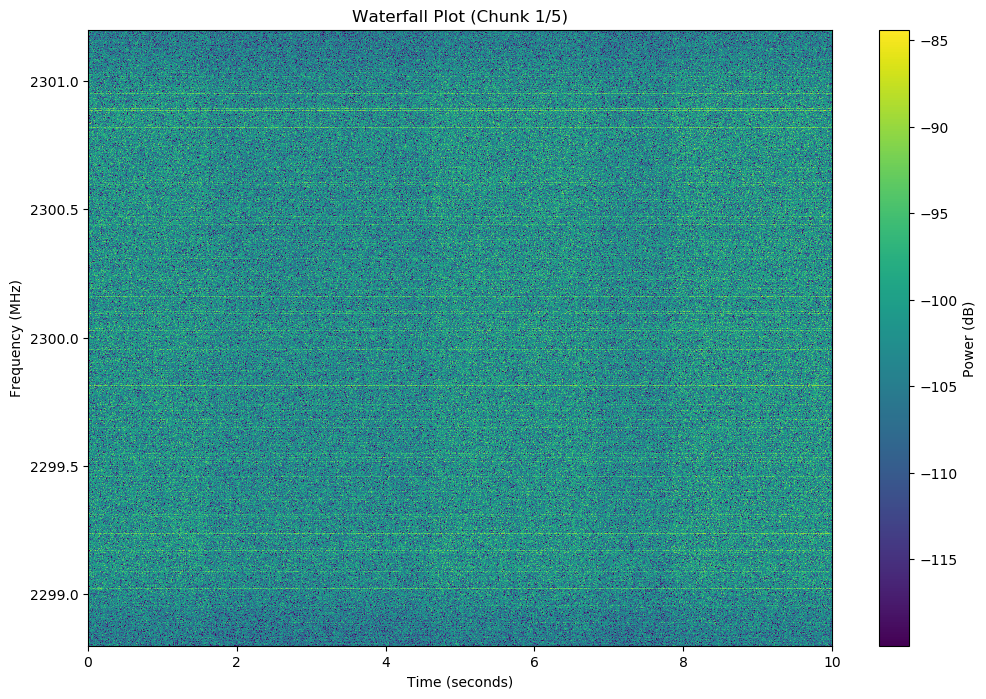

Обработан чанк 2/5: время от 10.00 до 20.00 сек


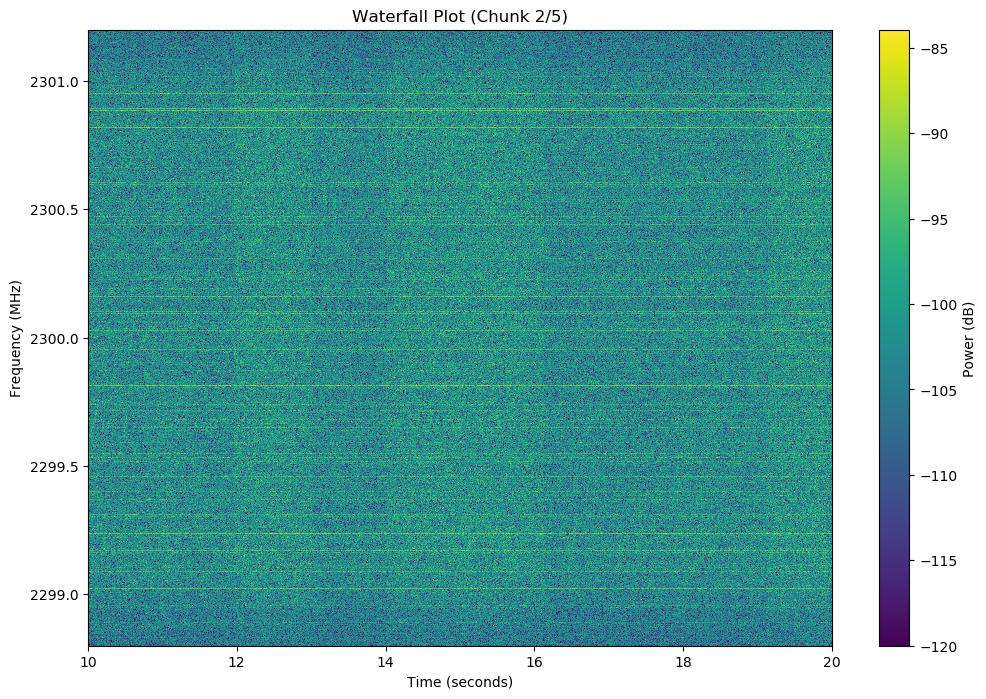

Обработан чанк 3/5: время от 20.00 до 30.00 сек


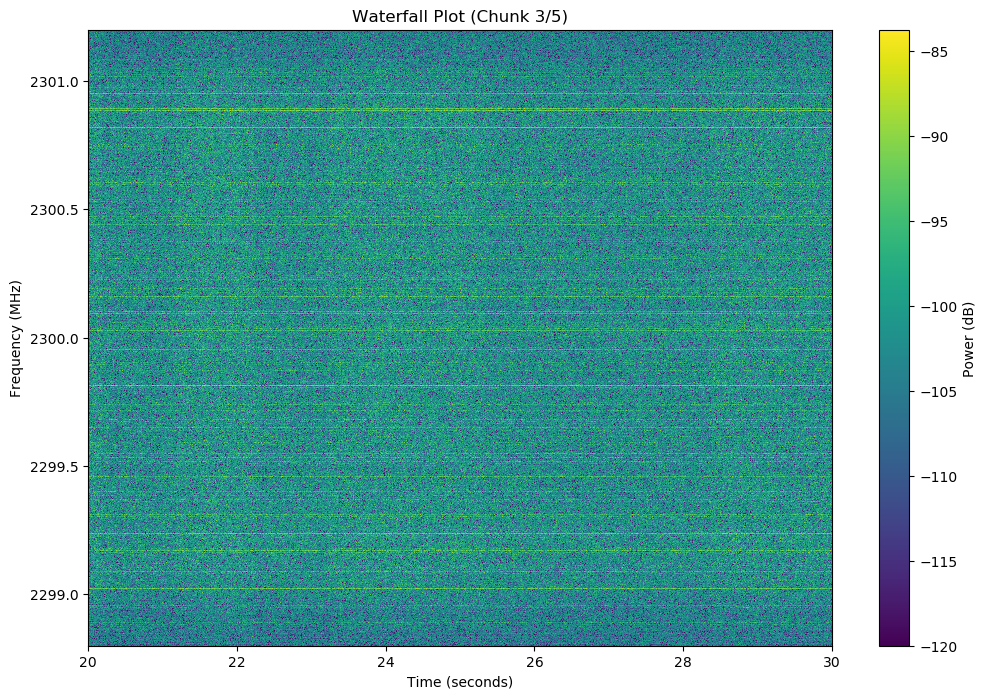

Обработан чанк 4/5: время от 30.00 до 40.00 сек


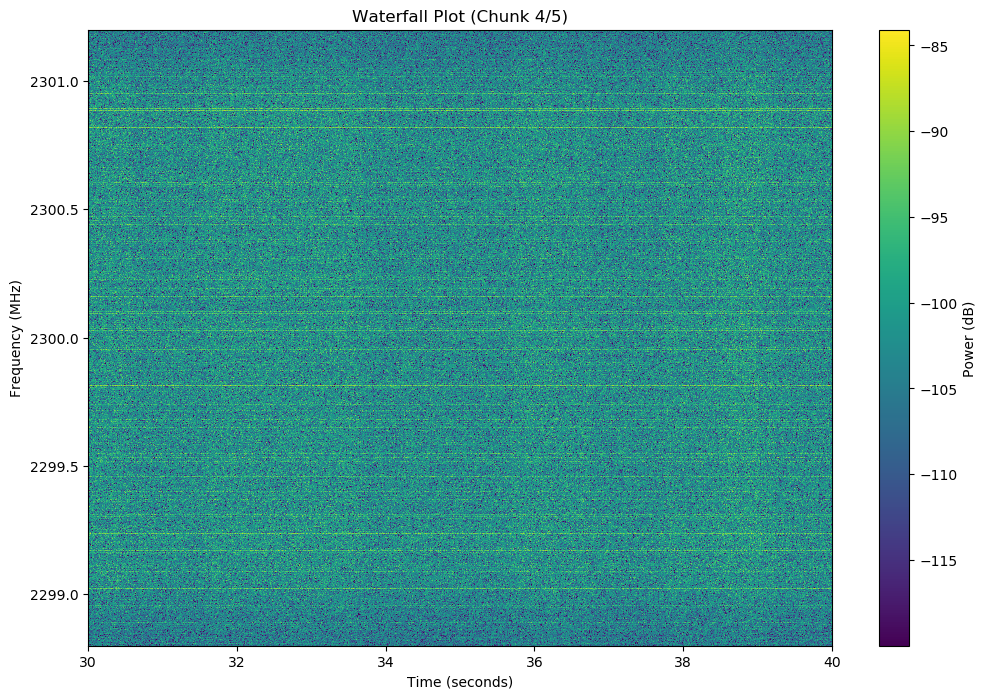

Обработан чанк 5/5: время от 40.00 до 42.87 сек


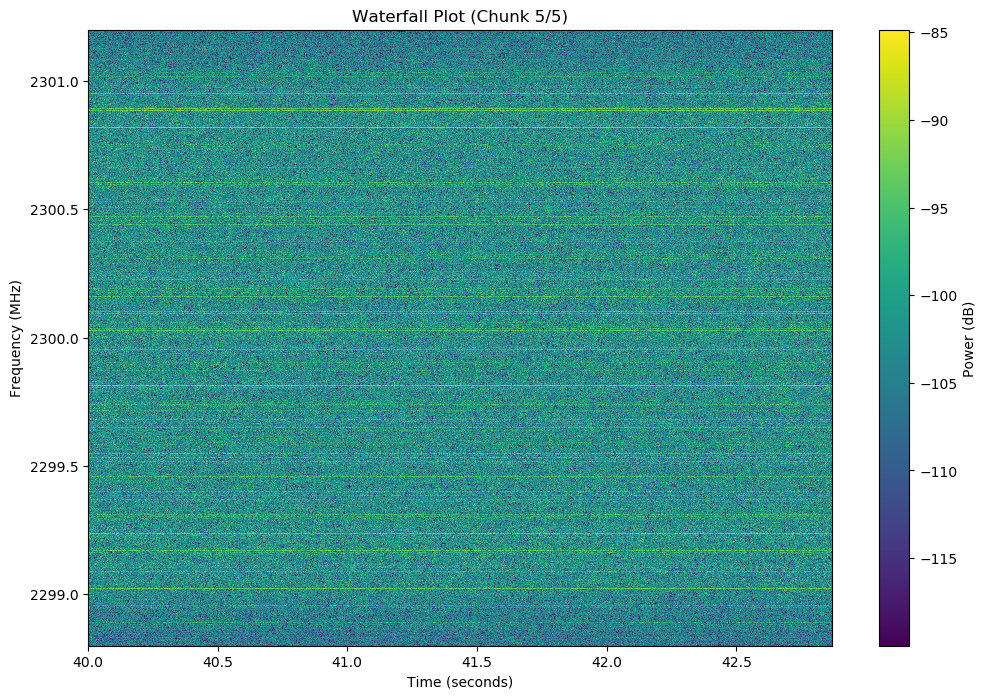

Waterfall сгенерирован по чанкам с глобальными временными метками.


In [112]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import os
import gc

# Параметры (настройте)
filename = '200cm2300_20251208_203713_2300000000_2400000_fc.raw'  # Ваш RAW файл
chunk_duration_sec = 10  # Размер чанка в сек (для 23 сек — 3 чанка)
nperseg = 4096  # Размер FFT-окна
noverlap_factor = 0.5  # Доля overlap
use_imshow = True  # True: imshow для скорости; False: pcolormesh

# Парсинг из имени файла
base = os.path.basename(filename)
parts = base.split('_')
center_freq = int(parts[3])  # 2400000000
sample_rate = int(parts[4])  # 2400000
print(f"Parsed center frequency: {center_freq / 1e6} MHz")
print(f"Parsed sample rate: {sample_rate / 1e6} MS/s")

# Загрузка как memmap (complex64)
iq_data = np.memmap(filename, dtype=np.complex64, mode='r')
total_samples = len(iq_data)
total_duration = total_samples / sample_rate
print(f"Loaded {total_samples} complex samples")
print(f"Total duration: {total_duration:.2f} seconds")

# Обработка по чанкам
chunk_samples = int(chunk_duration_sec * sample_rate)
n_chunks = int(np.ceil(total_samples / chunk_samples))

for chunk_idx in range(n_chunks):
    start = chunk_idx * chunk_samples
    end = min(start + chunk_samples, total_samples)
    chunk_iq = iq_data[start:end]
    
    if len(chunk_iq) < nperseg:
        print(f"Чанк {chunk_idx+1}/{n_chunks} слишком короткий, пропускаем.")
        continue
    
    noverlap = int(nperseg * noverlap_factor)
    f, t, Sxx = signal.spectrogram(chunk_iq, fs=sample_rate, nperseg=nperseg, noverlap=noverlap, return_onesided=False)
    f = np.fft.fftshift(f)
    Sxx_db = 10 * np.log10(np.fft.fftshift(Sxx, axes=0) + 1e-12)
    
    # Смещение времени для глобальных меток
    chunk_start_time = start / sample_rate
    t += chunk_start_time
    
    print(f"Обработан чанк {chunk_idx+1}/{n_chunks}: время от {t.min():.2f} до {t.max():.2f} сек")
    
    # Plot
    plt.figure(figsize=(12, 8))
    if use_imshow:
        plt.imshow(Sxx_db, aspect='auto', extent=[t.min(), t.max(), (f.min() + center_freq) / 1e6, (f.max() + center_freq) / 1e6], 
                   origin='lower', cmap='viridis', interpolation='nearest')
    else:
        plt.pcolormesh(t, (f + center_freq) / 1e6, Sxx_db, shading='gouraud', cmap='viridis')
    
    plt.ylabel('Frequency (MHz)')
    plt.xlabel('Time (seconds)')
    plt.title(f'Waterfall Plot (Chunk {chunk_idx+1}/{n_chunks})')
    plt.colorbar(label='Power (dB)')
    plt.show()
    
    gc.collect()

print("Waterfall сгенерирован по чанкам с глобальными временными метками.")

Parsed sample rate: 2.4 MS/s
Loaded 102888638 complex samples
Total duration: 42.87 seconds
Saved CSV: decoded_bits.csv
Saved TXT: decoded_bits.txt

Decoded bits (first 200):
 001100101100010111100011011101101000


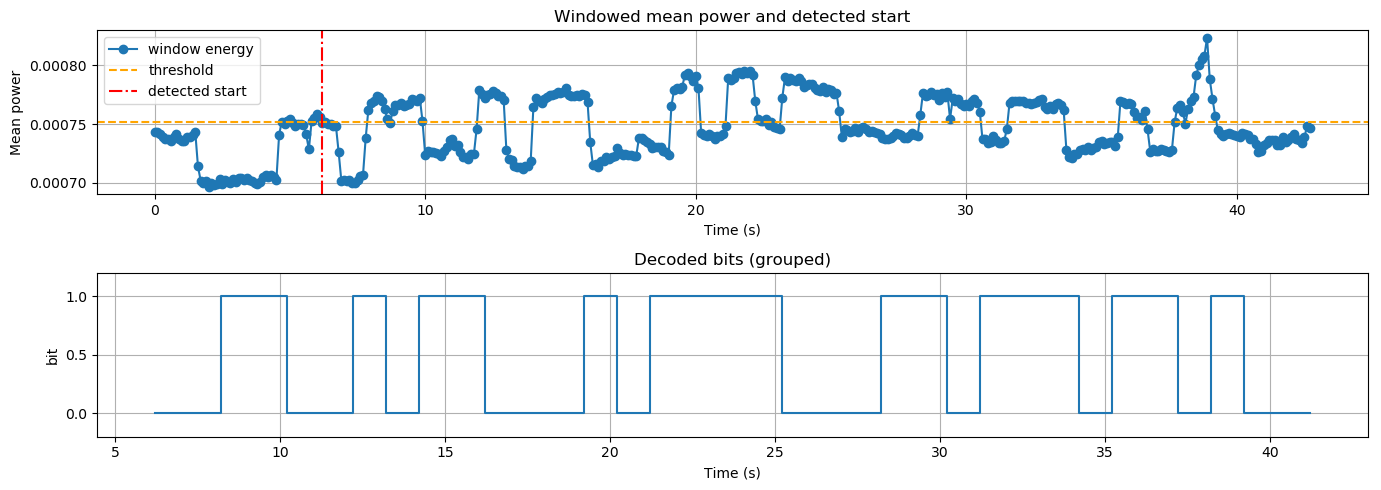

{'sample_rate': 2400000,
 'window_sec': 0.1,
 'bit_duration': 1,
 'windows_per_bit': 10,
 'energies': array([0.0007432 , 0.00074353, 0.00074166, 0.00073914, 0.00073747,
        0.00073702, 0.00073571, 0.00073897, 0.0007418 , 0.00073757,
        0.00073562, 0.00073526, 0.00073879, 0.00073946, 0.00074115,
        0.00074354, 0.00071407, 0.00070187, 0.00069978, 0.0007012 ,
        0.00069667, 0.00069966, 0.00069833, 0.00069871, 0.00070335,
        0.00069891, 0.00070203, 0.00070068, 0.00069969, 0.00070326,
        0.00070092, 0.00070424, 0.00070384, 0.00070266, 0.00070388,
        0.00070221, 0.00070173, 0.00069972, 0.00069945, 0.00070084,
        0.00070521, 0.0007063 , 0.00070534, 0.00070685, 0.0007049 ,
        0.00070286, 0.00074102, 0.00075224, 0.00075022, 0.00075244,
        0.00075446, 0.00075055, 0.0007484 , 0.0007498 , 0.0007501 ,
        0.00074951, 0.00074139, 0.00072847, 0.00075227, 0.00075535,
        0.00075837, 0.0007558 , 0.0007512 , 0.00075145, 0.00074996,
        0.00074

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

# Utility: 2-cluster threshold (без изменений)
def two_cluster_threshold(vals, max_iters=100, tol=1e-6):
    vals = vals.astype(float)
    c1, c2 = vals.min(), vals.max()
    for _ in range(max_iters):
        d1 = np.abs(vals - c1)
        d2 = np.abs(vals - c2)
        mask = d1 <= d2
        new_c1 = vals[mask].mean() if mask.any() else c1
        new_c2 = vals[~mask].mean() if (~mask).any() else c2
        if abs(new_c1 - c1) < tol and abs(new_c2 - c2) < tol:
            break
        c1, c2 = new_c1, new_c2
    return (c1 + c2) / 2.0, (c1, c2)

# Main decoding function (адаптировано для RAW complex64, память-оптимизировано)
def decode_energy_bits_from_raw(path,
                                window_sec=1.0,
                                bit_duration=None,
                                map_high_to=1,
                                save_prefix="decoded_bits",
                                detect_start=True,
                                min_bit_consensus=0.5,
                                smooth_runs_min_sec=0.0):
    # Парсинг sample_rate из имени
    base = os.path.basename(path)
    parts = base.split('_')
    sample_rate = int(parts[4])  # 2400000 из имени
    print(f"Parsed sample rate: {sample_rate / 1e6} MS/s")

    # Memmap как complex64
    iq_data = np.memmap(path, dtype=np.complex64, mode='r')
    total_samples = len(iq_data)
    total_duration = total_samples / sample_rate
    print(f"Loaded {total_samples} complex samples")
    print(f"Total duration: {total_duration:.2f} seconds")

    w_s = int(max(1, round(window_sec * sample_rate)))
    n_windows = total_samples // w_s
    if n_windows == 0:
        raise ValueError("Слишком короткий файл для заданного window_sec")

    # Вычисление energies по мини-чанкам (без полной power-array)
    energies = np.empty(n_windows, dtype=np.float64)
    for i in range(n_windows):
        start_s = i * w_s
        end_s = start_s + w_s
        chunk = iq_data[start_s:end_s]
        power_chunk = np.abs(chunk)**2
        energies[i] = power_chunk.mean()

    # Optional smoothing (без изменений)
    if smooth_runs_min_sec and smooth_runs_min_sec > 0:
        min_runs = max(1, int(np.round(smooth_runs_min_sec / window_sec)))
        med = np.median(energies)
        b0 = (energies >= med).astype(int)
        b = b0.copy()
        i = 0
        while i < len(b):
            j = i + 1
            while j < len(b) and b[j] == b[i]:
                j += 1
            run_len = j - i
            if run_len < min_runs:
                left = b[i-1] if i > 0 else None
                right = b[j] if j < len(b) else None
                if left is None and right is not None:
                    b[i:j] = right
                elif right is None and left is not None:
                    b[i:j] = left
                elif left is not None and right is not None:
                    b[i:j] = 1 if (left + right) >= 1 else 0
            i = j
        energies = energies.copy()
        i = 0
        while i < len(energies):
            j = i + 1
            while j < len(energies) and b[j] == b[i]:
                j += 1
            run_len = j - i
            if run_len < min_runs:
                left_val = energies[i-1] if i > 0 else energies[j] if j < len(energies) else energies[i]
                right_val = energies[j] if j < len(energies) else energies[i]
                energies[i:j] = (left_val + right_val) / 2.0
            i = j

    # Threshold и bits_raw (без изменений)
    threshold, centers = two_cluster_threshold(energies)
    bits_raw = (energies >= threshold).astype(int)
    if map_high_to == 0:
        bits_raw = 1 - bits_raw

    # Times
    times = np.arange(n_windows) * window_sec

    # Bit duration и группировка (без изменений)
    if bit_duration is None:
        bit_duration = window_sec
    windows_per_bit = max(1, int(round(bit_duration / window_sec)))

    # Detect start (без изменений)
    start_index = 0
    if detect_start:
        diffs = np.where(np.diff(bits_raw) != 0)[0] + 1
        chosen = None
        for idx in diffs:
            j = idx
            while j < len(bits_raw) and bits_raw[j] == bits_raw[idx]:
                j += 1
            run_right = j - idx
            i = idx - 1
            while i >= 0 and bits_raw[i] == bits_raw[idx-1]:
                i -= 1
            run_left = (idx - 1) - i
            if run_right >= windows_per_bit or (run_right >= max(1, windows_per_bit//2) and run_left >= max(1, windows_per_bit//2)):
                chosen = idx
                break
        if chosen is None and diffs.size > 0:
            chosen = diffs[0]
        if chosen is not None:
            start_index = chosen

    # Group into bits (без изменений)
    available_windows = n_windows - start_index
    n_bits = available_windows // windows_per_bit
    decoded_bits = []
    decoded_times = []
    decoded_energies = []
    for bidx in range(n_bits):
        s = start_index + bidx * windows_per_bit
        e = s + windows_per_bit
        slice_bits = bits_raw[s:e]
        val_fraction = slice_bits.mean()
        bit = 1 if val_fraction >= min_bit_consensus else 0
        decoded_bits.append(bit)
        decoded_times.append(times[s])
        decoded_energies.append(energies[s:e].mean())

    decoded_bits = np.array(decoded_bits, dtype=int)
    decoded_times = np.array(decoded_times)
    decoded_energies = np.array(decoded_energies)

    # Save (без изменений)
    df = pd.DataFrame({
        "time_start_s": decoded_times,
        "energy_mean": decoded_energies,
        "bit": decoded_bits,
    })
    csv_path = f"{save_prefix}.csv"
    txt_path = f"{save_prefix}.txt"
    df.to_csv(csv_path, index=False)
    with open(txt_path, "w") as f:
        f.write("".join(str(b) for b in decoded_bits))
    print("Saved CSV:", csv_path)
    print("Saved TXT:", txt_path)
    print("\nDecoded bits (first 200):\n", "".join(str(b) for b in decoded_bits[:200]))

    # Plot (без изменений, но время теперь правильное)
    plt.figure(figsize=(14,5))
    plt.subplot(2,1,1)
    plt.title("Windowed mean power and detected start")
    plt.plot(times, energies, '-o', label='window energy')
    plt.axhline(threshold, color='orange', linestyle='--', label='threshold')
    plt.axvline(start_index*window_sec, color='red', linestyle='-.', label='detected start')
    plt.xlabel('Time (s)')
    plt.ylabel('Mean power')
    plt.grid(True)
    plt.legend()
    plt.subplot(2,1,2)
    plt.title('Decoded bits (grouped)')
    if len(decoded_times) > 0:
        plt.step(decoded_times, decoded_bits, where='post')
    plt.ylim(-0.2, 1.2)
    plt.xlabel('Time (s)')
    plt.ylabel('bit')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return {
        "sample_rate": sample_rate,
        "window_sec": window_sec,
        "bit_duration": bit_duration,
        "windows_per_bit": windows_per_bit,
        "energies": energies,
        "threshold": threshold,
        "centers": centers,
        "start_index": start_index,
        "start_time_s": float(start_index * window_sec),
        "decoded_bits": decoded_bits,
        "csv": csv_path,
        "txt": txt_path
    }

# Вызов (измените параметры, если нужно)
decode_energy_bits_from_raw('200cm2300_20251208_203713_2300000000_2400000_fc.raw', window_sec=0.1, bit_duration=1)

Андрюхина динамическая схема

Parsed sample rate: 2.400 MS/s
[-0.0078125+0.015625j  -0.0234375+0.0078125j  0.       +0.0234375j ...
 -0.015625 +0.03125j    0.015625 +0.015625j  -0.015625 +0.015625j ]
Loaded 102888638 complex samples
Total duration: 42.87 seconds
Processing window 1/857, samples 0-120000, power_chunk: len=120000
Processing window 2/857, samples 120000-240000, power_chunk: len=120000
Processing window 3/857, samples 240000-360000, power_chunk: len=120000
Processing window 4/857, samples 360000-480000, power_chunk: len=120000
Processing window 5/857, samples 480000-600000, power_chunk: len=120000
Processing window 6/857, samples 600000-720000, power_chunk: len=120000
Processing window 7/857, samples 720000-840000, power_chunk: len=120000
Processing window 8/857, samples 840000-960000, power_chunk: len=120000
Processing window 9/857, samples 960000-1080000, power_chunk: len=120000
Processing window 10/857, samples 1080000-1200000, power_chunk: len=120000
Processing window 11/857, samples 1200000-132000

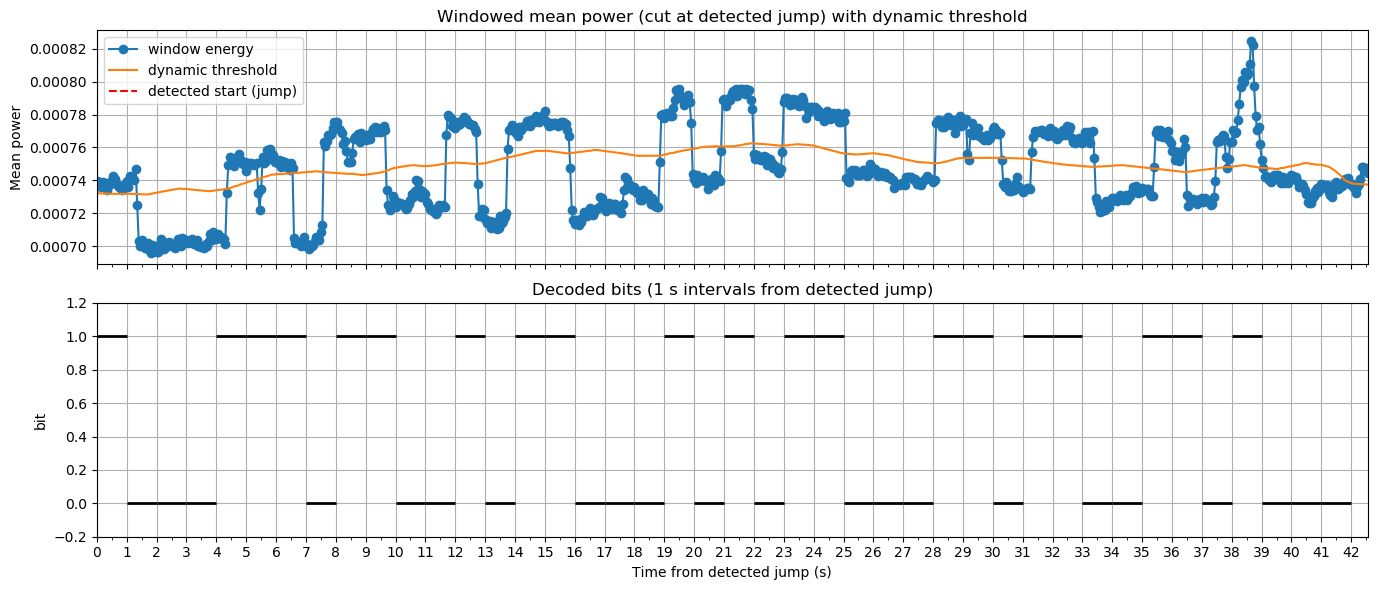

In [114]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.ticker import MultipleLocator

FIRST_THRESHOLD = 2

def sliding_mean_threshold(times,
                           energies,
                           look_back_sec=2.5,
                           look_ahead_sec=2.5):
    """
    Динамический порог: для каждой точки берём среднее энергии
    в окне [t - look_back_sec, t + look_ahead_sec).
    """
    thresholds = np.empty_like(energies, dtype=float)
    for i, t in enumerate(times):
        start = t - look_back_sec
        end = t + look_ahead_sec
        mask = (times >= start) & (times < end)
        window = energies[mask]
        if window.size:
            thresholds[i] = window.mean()
        else:
            thresholds[i] = energies[i]  # запасной вариант
    return thresholds


def _compute_energies_and_times(iq_data, sample_rate, window_sec):
    """
    Вспомогательная функция: вычисляет энергии по окнам и ось времени.
    """
    total_samples = len(iq_data)
    w_s = int(max(1, round(window_sec * sample_rate)))
    n_windows = total_samples // w_s
    if n_windows == 0:
        raise ValueError("Слишком короткий файл для заданного window_sec")

    energies = np.empty(n_windows, dtype=np.float64)
    for i in range(n_windows):
        start_s = i * w_s
        end_s = start_s + w_s
        chunk = iq_data[start_s:end_s]
        power_chunk = np.abs(chunk) ** 2
        print(f"Processing window {i+1}/{n_windows}, samples {start_s}-{end_s}, power_chunk: len={len(power_chunk)}")
        energies[i] = power_chunk.mean()

    times = np.arange(n_windows, dtype=float) * window_sec
    return energies, times, w_s


def detect_first_jump(energies, times):
    """
    Реализация твоего плана:

    - идём по массиву энергий;
    - считаем разницу между новой точкой и последней сохранённой точкой;
    - считаем дельту между сохранённой исторической дельтой и этой разницей;
    - если новая дельта >= 2 * исторической дельты -> возвращаем эту точку.

    Возвращает (idx, energy, time) или (None, None, None), если скачок не найден.
    """
    n = len(energies)
    if n < 2:
        return None, None, None

    saved_energy_point = energies[0]
    last_delta = 0.0  # историческая дельта, на нулевом шаге 0

    for i in range(1, n):
        last_point = saved_energy_point
        diff = abs(energies[i] - last_point)          # разница новой точки и последней сохранённой
        new_delta = abs(diff - last_delta)       # дельта между сохранённой исторической дельтой и новой разницей

        # условие: новая дельта в 2 раза больше исторической
        if last_delta > 0 and new_delta >= FIRST_THRESHOLD * last_delta:
            return i, energies[i], times[i]

        # обновляем историческую дельту и сохраняем точку
        last_delta = (diff+last_delta)/2
        saved_energy_point = energies[i]

    return None, None, None


def decode_energy_bits_dynamic(path,
                               window_sec=0.2,
                               look_back_sec=3.0,
                               look_ahead_sec=1.0,
                               bit_sec=1.0,
                               min_bit_consensus=0.5,
                               save_prefix="decoded_bits_dynamic"):
    """
    1) Считаем энергии по окнам (по всему файлу).
    2) На массиве энергий ищем первую "резкую" точку по алгоритму detect_first_jump.
    3) Обрезаем energies и times так, чтобы начинались с этой точки (t=0).
    4) По обрезанным данным считаем динамический трешхолд, биты и группируем по bit_sec.
    """

    # --- Парсинг sample_rate из имени файла ---
    base = os.path.basename(path)
    parts = base.split('_')
    sample_rate = int(parts[4])  # например, 2400000
    print(f"Parsed sample rate: {sample_rate / 1e6:.3f} MS/s")

    # --- Чтение IQ данных (memmap) ---
    iq_data = np.memmap(path, dtype=np.complex64, mode='r')
    print(iq_data)
    total_samples = len(iq_data)
    total_duration = total_samples / sample_rate
    print(f"Loaded {total_samples} complex samples")
    print(f"Total duration: {total_duration:.2f} seconds")

    # --- Энергии и времена по всему файлу ---
    energies_full, times_full, w_s = _compute_energies_and_times(
        iq_data, sample_rate, window_sec
    )

    # --- Поиск первого "скачка" по твоему алгоритму ---
    start_idx, start_energy, start_time = detect_first_jump(energies_full, times_full)
    if start_idx is None:
        print("[START DETECT] Скачок по правилу 2×delta не найден, начинаем с 0")
        start_idx = 0
        start_energy = energies_full[0]
        start_time = times_full[0]
    else:
        print(
            f"[START DETECT] First jump at index {start_idx}, "
            f"time {start_time:.3f} s, energy {start_energy}"
        )

    # --- Обрезаем энергии и времена так, чтобы начинались с этой точки ---
    energies = energies_full[start_idx:].copy()
    times_shifted = times_full[start_idx:] - start_time  # теперь t=0 в точке скачка

    # --- Динамический порог по обрезанным данным ---
    dyn_threshold = sliding_mean_threshold(
        times_shifted, energies,
        look_back_sec=look_back_sec,
        look_ahead_sec=look_ahead_sec
    )
    dyn_bits = (energies >= dyn_threshold).astype(int)

    # --- Группировка в биты по bit_sec, начиная с t=0 ---
    end_time = float(times_shifted[-1] + window_sec)
    n_bits = max(0, int(np.floor(end_time / bit_sec)))

    decoded_bits = []
    decoded_times = []
    decoded_energies = []

    for b_idx in range(n_bits):
        t0 = b_idx * bit_sec
        t1 = t0 + bit_sec
        mask = (times_shifted >= t0) & (times_shifted < t1)
        if not mask.any():
            continue

        slice_bits = dyn_bits[mask]
        slice_energies = energies[mask]

        val_fraction = slice_bits.mean()
        bit = 1 if val_fraction >= min_bit_consensus else 0

        decoded_bits.append(bit)
        decoded_times.append(t0)  # время от точки скачка
        decoded_energies.append(slice_energies.mean())

    decoded_bits = np.array(decoded_bits, dtype=int)
    decoded_times = np.array(decoded_times, dtype=float)
    decoded_energies = np.array(decoded_energies, dtype=float)

    # --- Сохранение результата ---
    df = pd.DataFrame({
        "time_start_s": decoded_times,   # время от первого скачка
        "energy_mean": decoded_energies,
        "bit": decoded_bits,
    })
    csv_path = f"{save_prefix}.csv"
    txt_path = f"{save_prefix}.txt"

    df.to_csv(csv_path, index=False)
    with open(txt_path, "w") as f:
        f.write("".join(str(b) for b in decoded_bits))

    print("Saved CSV:", csv_path)
    print("Saved TXT:", txt_path)
    print("\nDecoded bits (first 200):\n", "".join(str(b) for b in decoded_bits[:200]))

    # --- Визуализация ---
    if len(times_shifted) > 0:
        common_xlim = (0.0, float(times_shifted[-1]))
    else:
        common_xlim = (0.0, 0.0)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # Энергия и динамический порог после обрезки
    ax1.set_title("Windowed mean power (cut at detected jump) with dynamic threshold")
    ax1.plot(times_shifted, energies, "-o", label="window energy")
    ax1.plot(times_shifted, dyn_threshold, label="dynamic threshold")
    ax1.axvline(0.0, color="red", linestyle="--", label="detected start (jump)")
    ax1.set_ylabel("Mean power")
    ax1.grid(True)
    ax1.legend()
    ax1.xaxis.set_major_locator(MultipleLocator(1.0))
    ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax1.set_xlim(*common_xlim)

    # Декодированные биты по секундным интервалам
    ax2.set_title("Decoded bits (1 s intervals from detected jump)")
    if len(decoded_times) > 0:
        for t0, bit in zip(decoded_times, decoded_bits):
            t1 = t0 + bit_sec
            ax2.hlines(bit, t0, t1, linewidth=2)
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_xlabel("Time from detected jump (s)")
    ax2.set_ylabel("bit")
    ax2.grid(True)
    ax2.xaxis.set_major_locator(MultipleLocator(1.0))
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.set_xlim(*common_xlim)

    fig.tight_layout()
    plt.show()

    return {
        "sample_rate": sample_rate,
        "window_sec": window_sec,
        "bit_sec": bit_sec,
        "look_back_sec": look_back_sec,
        "look_ahead_sec": look_ahead_sec,
        "energies_cut": energies,
        "times_cut": times_shifted,
        "dyn_threshold": dyn_threshold,
        "dyn_bits": dyn_bits,
        "start_index_full": start_idx,
        "start_time_full_s": start_time,
        "start_energy_full": start_energy,
        "decoded_bits": decoded_bits,
        "decoded_times": decoded_times,
        "decoded_energies": decoded_energies,
        "csv": csv_path,
        "txt": txt_path,
    }


# Пример вызова:
res = decode_energy_bits_dynamic(
    "200cm2300_20251208_203713_2300000000_2400000_fc.raw",
    window_sec=0.05,
    look_back_sec=3.0,
    look_ahead_sec=10.0,
    bit_sec=1.0,
    min_bit_consensus=0.5,
    save_prefix="decoded_bits_dynamic"
)


Никитоса динамическая схема, добавлено усреднение по спектру

Parsed sample rate: 2.400 MS/s
Loaded 102888638 complex samples
Total duration: 42.87 seconds
Processing window 1/857, samples 0-120000, chunk len=120000
Processing window 2/857, samples 120000-240000, chunk len=120000
Processing window 3/857, samples 240000-360000, chunk len=120000
Processing window 4/857, samples 360000-480000, chunk len=120000
Processing window 5/857, samples 480000-600000, chunk len=120000
Processing window 6/857, samples 600000-720000, chunk len=120000
Processing window 7/857, samples 720000-840000, chunk len=120000
Processing window 8/857, samples 840000-960000, chunk len=120000
Processing window 9/857, samples 960000-1080000, chunk len=120000
Processing window 10/857, samples 1080000-1200000, chunk len=120000
Processing window 11/857, samples 1200000-1320000, chunk len=120000
Processing window 12/857, samples 1320000-1440000, chunk len=120000
Processing window 13/857, samples 1440000-1560000, chunk len=120000
Processing window 14/857, samples 1560000-1680000, ch

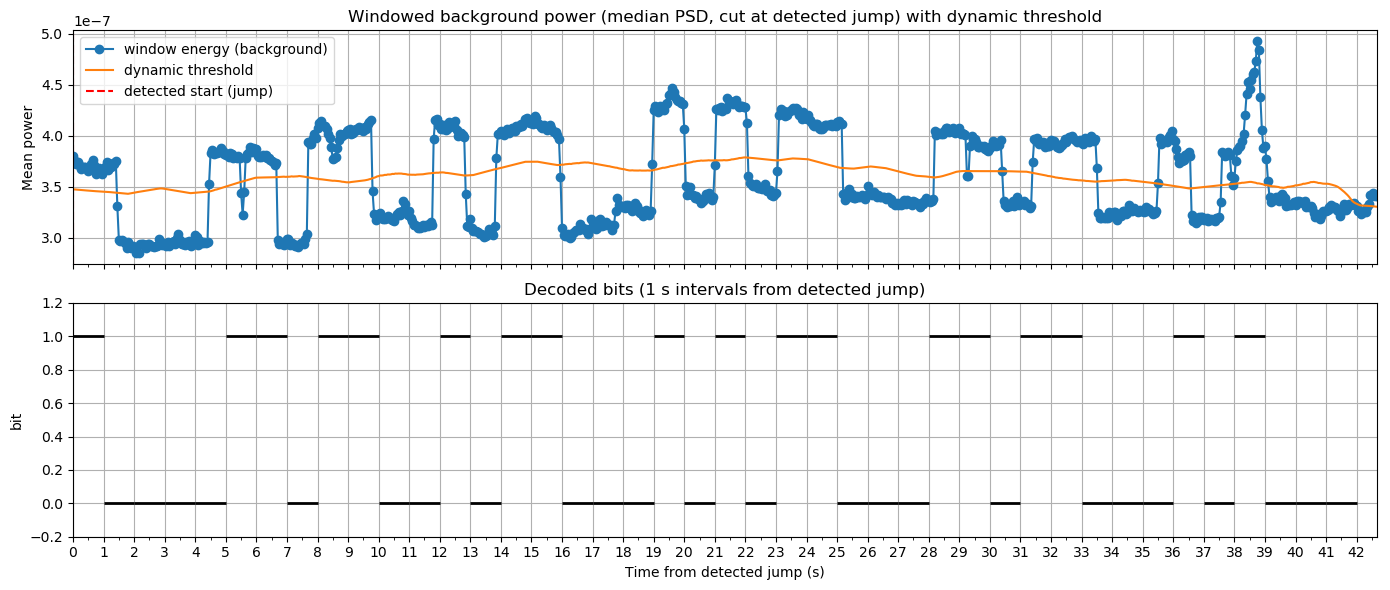

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.ticker import MultipleLocator
from scipy.signal import welch  # Для PSD

FIRST_THRESHOLD = 2

def sliding_mean_threshold(times,
                           energies,
                           look_back_sec=2.5,
                           look_ahead_sec=2.5):
    """
    Динамический порог: для каждой точки берём среднее энергии
    в окне [t - look_back_sec, t + look_ahead_sec).
    """
    thresholds = np.empty_like(energies, dtype=float)
    for i, t in enumerate(times):
        start = t - look_back_sec
        end = t + look_ahead_sec
        mask = (times >= start) & (times < end)
        window = energies[mask]
        if window.size:
            thresholds[i] = window.mean()
        else:
            thresholds[i] = energies[i]  # запасной вариант
    return thresholds


def _compute_energies_and_times(iq_data, sample_rate, window_sec,
                                welch_nperseg=4096):  # Увеличено для разрешения как в waterfall
    """
    Вспомогательная функция: вычисляет энергии по окнам и ось времени.
    Теперь с freq-анализом: welch PSD, энергия = медиана(Pxx) * len(Pxx) для фона (игнор пиков).
    """
    total_samples = len(iq_data)
    w_s = int(max(1, round(window_sec * sample_rate)))
    n_windows = total_samples // w_s
    if n_windows == 0:
        raise ValueError("Слишком короткий файл для заданного window_sec")

    energies = np.empty(n_windows, dtype=np.float64)
    for i in range(n_windows):
        start_s = i * w_s
        end_s = start_s + w_s
        chunk = iq_data[start_s:end_s]
        print(f"Processing window {i+1}/{n_windows}, samples {start_s}-{end_s}, chunk len={len(chunk)}")
        
        # Welch PSD: f, Pxx (мощность на freq)
        f, Pxx = welch(chunk, fs=sample_rate, nperseg=welch_nperseg, return_onesided=False)
        f = np.fft.fftshift(f)  # Центр на 0
        Pxx = np.fft.fftshift(Pxx)
        
        # Энергия как медиана Pxx * число бинов (уровень фона, устойчив к пикам)
        if len(Pxx) > 0:
            energies[i] = np.median(Pxx) * len(Pxx)
            # energies[i] = np.sum(np.clip(Pxx, 0, np.percentile(Pxx, 95)))
        else:
            print("Warning: Empty Pxx array")
            energies[i] = 0.0

    times = np.arange(n_windows, dtype=float) * window_sec
    return energies, times, w_s


def detect_first_jump(energies, times):
    """
    Реализация твоего плана:

    - идём по массиву энергий;
    - считаем разницу между новой точкой и последней сохранённой точкой;
    - считаем дельту между сохранённой исторической дельтой и этой разницей;
    - если новая дельта >= 2 * исторической дельты -> возвращаем эту точку.

    Возвращает (idx, energy, time) или (None, None, None), если скачок не найден.
    """
    n = len(energies)
    if n < 2:
        return None, None, None

    saved_energy_point = energies[0]
    last_delta = 0.0  # историческая дельта, на нулевом шаге 0

    for i in range(1, n):
        last_point = saved_energy_point
        diff = abs(energies[i] - last_point)          # разница новой точки и последней сохранённой
        new_delta = abs(diff - last_delta)       # дельта между сохранённой исторической дельтой и новой разницей

        # условие: новая дельта в 2 раза больше исторической
        if last_delta > 0 and new_delta >= FIRST_THRESHOLD * last_delta:
            return i, energies[i], times[i]

        # обновляем историческую дельту и сохраняем точку
        last_delta = (diff + last_delta) / 2
        saved_energy_point = energies[i]

    return None, None, None


def decode_energy_bits_dynamic(path,
                               window_sec=0.2,
                               look_back_sec=3.0,
                               look_ahead_sec=1.0,
                               bit_sec=1.0,
                               min_bit_consensus=0.5,
                               welch_nperseg=4096,  # Как в waterfall
                               save_prefix="decoded_bits_dynamic"):
    """
    1) Считаем энергии по окнам (по всему файлу), теперь фон через медиану PSD.
    2) На массиве энергий ищем первую "резкую" точку по алгоритму detect_first_jump.
    3) Обрезаем energies и times так, чтобы начинались с этой точки (t=0).
    4) По обрезанным данным считаем динамический трешхолд, биты и группируем по bit_sec.
    """

    # --- Парсинг sample_rate из имени файла ---
    base = os.path.basename(path)
    parts = base.split('_')
    sample_rate = int(parts[4])  # например, 2400000
    print(f"Parsed sample rate: {sample_rate / 1e6:.3f} MS/s")

    # --- Чтение IQ данных (memmap) ---
    iq_data = np.memmap(path, dtype=np.complex64, mode='r')
    total_samples = len(iq_data)
    total_duration = total_samples / sample_rate
    print(f"Loaded {total_samples} complex samples")
    print(f"Total duration: {total_duration:.2f} seconds")

    # --- Энергии и времена по всему файлу (теперь с медианой для фона) ---
    energies_full, times_full, w_s = _compute_energies_and_times(
        iq_data, sample_rate, window_sec,
        welch_nperseg=welch_nperseg
    )

    # --- Поиск первого "скачка" по твоему алгоритму ---
    start_idx, start_energy, start_time = detect_first_jump(energies_full, times_full)
    if start_idx is None:
        print("[START DETECT] Скачок по правилу 2×delta не найден, начинаем с 0")
        start_idx = 0
        start_energy = energies_full[0]
        start_time = times_full[0]
    else:
        print(
            f"[START DETECT] First jump at index {start_idx}, "
            f"time {start_time:.3f} s, energy {start_energy}"
        )

    # --- Обрезаем энергии и времена так, чтобы начинались с этой точки ---
    energies = energies_full[start_idx:].copy()
    times_shifted = times_full[start_idx:] - start_time  # теперь t=0 в точке скачка

    # --- Динамический порог по обрезанным данным ---
    dyn_threshold = sliding_mean_threshold(
        times_shifted, energies,
        look_back_sec=look_back_sec,
        look_ahead_sec=look_ahead_sec
    )
    dyn_bits = (energies >= dyn_threshold).astype(int)

    # --- Группировка в биты по bit_sec, начиная с t=0 ---
    end_time = float(times_shifted[-1] + window_sec)
    n_bits = max(0, int(np.floor(end_time / bit_sec)))

    decoded_bits = []
    decoded_times = []
    decoded_energies = []

    for b_idx in range(n_bits):
        t0 = b_idx * bit_sec
        t1 = t0 + bit_sec
        mask = (times_shifted >= t0) & (times_shifted < t1)
        if not mask.any():
            continue

        slice_bits = dyn_bits[mask]
        slice_energies = energies[mask]

        val_fraction = slice_bits.mean()
        bit = 1 if val_fraction >= min_bit_consensus else 0

        decoded_bits.append(bit)
        decoded_times.append(t0)  # время от точки скачка
        decoded_energies.append(slice_energies.mean())

    decoded_bits = np.array(decoded_bits, dtype=int)
    decoded_times = np.array(decoded_times, dtype=float)
    decoded_energies = np.array(decoded_energies, dtype=float)

    # --- Сохранение результата ---
    df = pd.DataFrame({
        "time_start_s": decoded_times,   # время от первого скачка
        "energy_mean": decoded_energies,
        "bit": decoded_bits,
    })
    csv_path = f"{save_prefix}.csv"
    txt_path = f"{save_prefix}.txt"

    df.to_csv(csv_path, index=False)
    with open(txt_path, "w") as f:
        f.write("".join(str(b) for b in decoded_bits))

    print("Saved CSV:", csv_path)
    print("Saved TXT:", txt_path)
    print("\nDecoded bits (first 200):\n", "".join(str(b) for b in decoded_bits[:200]))

    # --- Визуализация ---
    if len(times_shifted) > 0:
        common_xlim = (0.0, float(times_shifted[-1]))
    else:
        common_xlim = (0.0, 0.0)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    # Энергия и динамический порог после обрезки
    ax1.set_title("Windowed background power (median PSD, cut at detected jump) with dynamic threshold")
    ax1.plot(times_shifted, energies, "-o", label="window energy (background)")
    ax1.plot(times_shifted, dyn_threshold, label="dynamic threshold")
    ax1.axvline(0.0, color="red", linestyle="--", label="detected start (jump)")
    ax1.set_ylabel("Mean power")
    ax1.grid(True)
    ax1.legend()
    ax1.xaxis.set_major_locator(MultipleLocator(1.0))
    ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax1.set_xlim(*common_xlim)

    # Декодированные биты по секундным интервалам
    ax2.set_title("Decoded bits (1 s intervals from detected jump)")
    if len(decoded_times) > 0:
        for t0, bit in zip(decoded_times, decoded_bits):
            t1 = t0 + bit_sec
            ax2.hlines(bit, t0, t1, linewidth=2)
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_xlabel("Time from detected jump (s)")
    ax2.set_ylabel("bit")
    ax2.grid(True)
    ax2.xaxis.set_major_locator(MultipleLocator(1.0))
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.set_xlim(*common_xlim)

    fig.tight_layout()
    plt.show()

    return {
        "sample_rate": sample_rate,
        "window_sec": window_sec,
        "bit_sec": bit_sec,
        "look_back_sec": look_back_sec,
        "look_ahead_sec": look_ahead_sec,
        "energies_cut": energies,
        "times_cut": times_shifted,
        "dyn_threshold": dyn_threshold,
        "dyn_bits": dyn_bits,
        "start_index_full": start_idx,
        "start_time_full_s": start_time,
        "start_energy_full": start_energy,
        "decoded_bits": decoded_bits,
        "decoded_times": decoded_times,
        "decoded_energies": decoded_energies,
        "csv": csv_path,
        "txt": txt_path,
    }


# Пример вызова:
res = decode_energy_bits_dynamic(
    "200cm2300_20251208_203713_2300000000_2400000_fc.raw",
    window_sec=0.05,
    look_back_sec=3.0,
    look_ahead_sec=10.0,
    bit_sec=1.0,
    min_bit_consensus=0.6,
    welch_nperseg=4096,
    save_prefix="decoded_bits_dynamic_median"
)

Никитоса динамическая схема, добавлено усреднение по спектру, более точное определение начала + сдвиг к окну, чтобы смотреть не только по секундам

Parsed sample rate: 2.400 MS/s
Loaded 102888638 complex samples
Total duration: 42.87 seconds
[START DETECT] First stable transition at index 1, time 0.200 s, energy 3.7482692505363957e-07
Saved CSV: decoded_bits_dynamic_median.csv
Saved TXT: decoded_bits_dynamic_median.txt

Decoded bits (first 200):
 10001101100101100010101100011011001010000


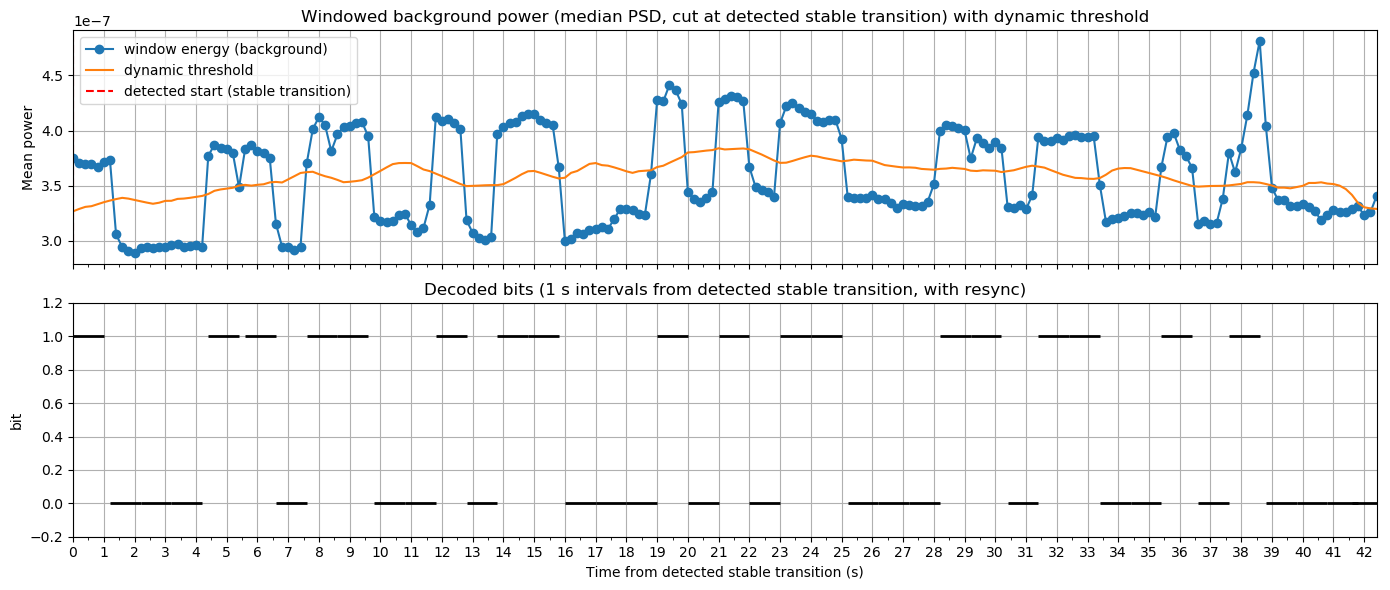

In [117]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from matplotlib.ticker import MultipleLocator
from scipy.signal import welch  # Для PSD

def two_cluster_threshold(vals, max_iters=100, tol=1e-6):
    vals = vals.astype(float)
    c1, c2 = vals.min(), vals.max()
    for _ in range(max_iters):
        d1 = np.abs(vals - c1)
        d2 = np.abs(vals - c2)
        mask = d1 <= d2
        new_c1 = vals[mask].mean() if mask.any() else c1
        new_c2 = vals[~mask].mean() if (~mask).any() else c2
        if abs(new_c1 - c1) < tol and abs(new_c2 - c2) < tol:
            break
        c1, c2 = new_c1, new_c2
    return (c1 + c2) / 2.0, (c1, c2)

def sliding_mean_threshold(times,
                           energies,
                           look_back_sec=2.5,
                           look_ahead_sec=2.5):
    thresholds = np.empty_like(energies, dtype=float)
    for i, t in enumerate(times):
        start = t - look_back_sec
        end = t + look_ahead_sec
        mask = (times >= start) & (times < end)
        window = energies[mask]
        if window.size:
            thresholds[i] = window.mean()
        else:
            thresholds[i] = energies[i]
    return thresholds

def _compute_energies_and_times(iq_data, sample_rate, window_sec,
                                welch_nperseg=4096):
    total_samples = len(iq_data)
    w_s = int(max(1, round(window_sec * sample_rate)))
    n_windows = total_samples // w_s
    if n_windows == 0:
        raise ValueError("Слишком короткий файл для заданного window_sec")

    energies = np.empty(n_windows, dtype=np.float64)
    for i in range(n_windows):
        start_s = i * w_s
        end_s = start_s + w_s
        chunk = iq_data[start_s:end_s]
        
        f, Pxx = welch(chunk, fs=sample_rate, nperseg=welch_nperseg, return_onesided=False)
        f = np.fft.fftshift(f)
        Pxx = np.fft.fftshift(Pxx)
        
        if len(Pxx) > 0:
            energies[i] = np.median(Pxx) * len(Pxx)
        else:
            energies[i] = 0.0

    times = np.arange(n_windows, dtype=float) * window_sec
    return energies, times, w_s

def detect_first_stable_transition(energies, times, window_sec, bit_sec=1.0, look_back_windows=50):
    """
    Улучшенный метод: бинаризация с sliding two_cluster + run-length check.
    Sliding: Для каждого потенциального idx используем threshold на последних look_back_windows.
    """
    windows_per_bit = max(1, int(round(bit_sec / window_sec)))
    diffs = []  # Соберём кандидаты позже

    # Для бинаризации используем sliding window
    bits_raw = np.zeros(len(energies), dtype=int)
    for i in range(len(energies)):
        start_win = max(0, i - look_back_windows + 1)
        window_energies = energies[start_win:i+1]
        if len(window_energies) < 2:
            threshold = np.median(window_energies) if len(window_energies) else 0
        else:
            threshold, _ = two_cluster_threshold(window_energies)
        bits_raw[i] = 1 if energies[i] >= threshold else 0

    # Теперь diffs на bits_raw
    diffs = np.where(np.diff(bits_raw) != 0)[0] + 1
    chosen = None
    for idx in diffs:
        j = idx
        while j < len(bits_raw) and bits_raw[j] == bits_raw[idx]:
            j += 1
        run_right = j - idx
        i = idx - 1
        while i >= 0 and bits_raw[i] == bits_raw[idx-1]:
            i -= 1
        run_left = (idx - 1) - i
        if run_right >= windows_per_bit or (run_right >= max(1, windows_per_bit//2) and run_left >= max(1, windows_per_bit//2)):
            chosen = idx
            break
    if chosen is None and diffs.size > 0:
        chosen = diffs[0]
    if chosen is not None:
        return chosen, energies[chosen], times[chosen]
    return None, None, None

def decode_energy_bits_dynamic(path,
                               window_sec=0.2,
                               look_back_sec=3.0,
                               look_ahead_sec=1.0,
                               bit_sec=1.0,
                               min_bit_consensus=0.5,
                               welch_nperseg=4096,
                               look_back_windows=50,  # Для sliding cluster
                               shift_step=0.5,  # Шаг сдвига окна при low confidence (в сек)
                               confidence_threshold=0.7,  # Min confidence для high (abs(val_fraction - 0.5)*2)
                               save_prefix="decoded_bits_dynamic_median"):
    base = os.path.basename(path)
    parts = base.split('_')
    sample_rate = int(parts[4])
    print(f"Parsed sample rate: {sample_rate / 1e6:.3f} MS/s")

    iq_data = np.memmap(path, dtype=np.complex64, mode='r')
    total_samples = len(iq_data)
    total_duration = total_samples / sample_rate
    print(f"Loaded {total_samples} complex samples")
    print(f"Total duration: {total_duration:.2f} seconds")

    energies_full, times_full, w_s = _compute_energies_and_times(
        iq_data, sample_rate, window_sec,
        welch_nperseg=welch_nperseg
    )

    start_idx, start_energy, start_time = detect_first_stable_transition(energies_full, times_full, window_sec, bit_sec, look_back_windows)
    if start_idx is None:
        print("[START DETECT] Stable transition not found, starting from 0")
        start_idx = 0
        start_energy = energies_full[0]
        start_time = times_full[0]
    else:
        print(f"[START DETECT] First stable transition at index {start_idx}, time {start_time:.3f} s, energy {start_energy}")

    energies = energies_full[start_idx:].copy()
    times_shifted = times_full[start_idx:] - start_time

    dyn_threshold = sliding_mean_threshold(
        times_shifted, energies,
        look_back_sec=look_back_sec,
        look_ahead_sec=look_ahead_sec
    )
    dyn_bits = (energies >= dyn_threshold).astype(int)

    end_time = float(times_shifted[-1] + window_sec if len(times_shifted) > 0 else 0)
    n_bits = max(0, int(np.ceil(end_time / bit_sec)))  # ceil для покрытия остатка

    decoded_bits = []
    decoded_times = []
    decoded_energies = []
    current_offset = 0.0  # Аккумулированный сдвиг для resync

    for b_idx in range(n_bits):
        t0 = b_idx * bit_sec + current_offset
        t1 = t0 + bit_sec
        mask = (times_shifted >= t0) & (times_shifted < t1)
        if not mask.any():
            continue

        slice_bits = dyn_bits[mask]
        slice_energies = energies[mask]

        val_fraction = slice_bits.mean()
        confidence = abs(val_fraction - 0.5) * 2  # 1.0 если 0 или 1, 0 если 0.5

        # Если low confidence, пробуем сдвиг и выбираем лучший
        if confidence < confidence_threshold:
            best_fraction = val_fraction
            best_bit = 1 if val_fraction >= min_bit_consensus else 0
            best_offset = 0.0
            for offset in [-shift_step, shift_step]:
                t0_shift = t0 + offset
                t1_shift = t1 + offset
                mask_shift = (times_shifted >= t0_shift) & (times_shifted < t1_shift)
                if mask_shift.any():
                    slice_bits_shift = dyn_bits[mask_shift]
                    fraction_shift = slice_bits_shift.mean()
                    if abs(fraction_shift - 0.5) > abs(best_fraction - 0.5):
                        best_fraction = fraction_shift
                        best_bit = 1 if fraction_shift >= min_bit_consensus else 0
                        best_offset = offset
            current_offset += best_offset  # Аккумулируем сдвиг для будущих окон
            val_fraction = best_fraction
            t0 += best_offset  # Корректируем t0 для этого бита

        bit = 1 if val_fraction >= min_bit_consensus else 0

        decoded_bits.append(bit)
        decoded_times.append(t0)
        decoded_energies.append(slice_energies.mean() if not mask.any() else np.mean(energies[mask_shift] if 'mask_shift' in locals() else slice_energies))

    decoded_bits = np.array(decoded_bits, dtype=int)
    decoded_times = np.array(decoded_times, dtype=float)
    decoded_energies = np.array(decoded_energies, dtype=float)

    df = pd.DataFrame({
        "time_start_s": decoded_times,
        "energy_mean": decoded_energies,
        "bit": decoded_bits,
    })
    csv_path = f"{save_prefix}.csv"
    txt_path = f"{save_prefix}.txt"

    df.to_csv(csv_path, index=False)
    with open(txt_path, "w") as f:
        f.write("".join(str(b) for b in decoded_bits))

    print("Saved CSV:", csv_path)
    print("Saved TXT:", txt_path)
    print("\nDecoded bits (first 200):\n", "".join(str(b) for b in decoded_bits[:200]))

    if len(times_shifted) > 0:
        common_xlim = (0.0, float(times_shifted[-1]))
    else:
        common_xlim = (0.0, 0.0)

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    ax1.set_title("Windowed background power (median PSD, cut at detected stable transition) with dynamic threshold")
    ax1.plot(times_shifted, energies, "-o", label="window energy (background)")
    ax1.plot(times_shifted, dyn_threshold, label="dynamic threshold")
    ax1.axvline(0.0, color="red", linestyle="--", label="detected start (stable transition)")
    ax1.set_ylabel("Mean power")
    ax1.grid(True)
    ax1.legend()
    ax1.xaxis.set_major_locator(MultipleLocator(1.0))
    ax1.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax1.set_xlim(*common_xlim)

    ax2.set_title("Decoded bits (1 s intervals from detected stable transition, with resync)")
    if len(decoded_times) > 0:
        for t0, bit in zip(decoded_times, decoded_bits):
            t1 = t0 + bit_sec
            ax2.hlines(bit, t0, t1, linewidth=2)
    ax2.set_ylim(-0.2, 1.2)
    ax2.set_xlabel("Time from detected stable transition (s)")
    ax2.set_ylabel("bit")
    ax2.grid(True)
    ax2.xaxis.set_major_locator(MultipleLocator(1.0))
    ax2.xaxis.set_minor_locator(MultipleLocator(0.5))
    ax2.set_xlim(*common_xlim)

    fig.tight_layout()
    plt.show()

    return {
        "sample_rate": sample_rate,
        "window_sec": window_sec,
        "bit_sec": bit_sec,
        "look_back_sec": look_back_sec,
        "look_ahead_sec": look_ahead_sec,
        "energies_cut": energies,
        "times_cut": times_shifted,
        "dyn_threshold": dyn_threshold,
        "dyn_bits": dyn_bits,
        "start_index_full": start_idx,
        "start_time_full_s": start_time,
        "start_energy_full": start_energy,
        "decoded_bits": decoded_bits,
        "decoded_times": decoded_times,
        "decoded_energies": decoded_energies,
        "csv": csv_path,
        "txt": txt_path,
    }

# Пример вызова (добавь shift_step и confidence_threshold если нужно изменить):
res = decode_energy_bits_dynamic(
    "200cm2300_20251208_203713_2300000000_2400000_fc.raw",
    window_sec=0.2,
    look_back_sec=3.0,
    look_ahead_sec=5.0,
    bit_sec=1.0,
    min_bit_consensus=0.5,
    welch_nperseg=4096,
    look_back_windows=50,
    shift_step=0.2,
    confidence_threshold=0.7,
    save_prefix="decoded_bits_dynamic_median"
)